In [1]:
import os

# os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import random
from datetime import datetime
from pprint import pprint

import keras
import numpy as np
import torch
from keras import layers, ops
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

2024-08-21 14:44:51.830555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 14:44:51.852626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 14:44:51.852643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 14:44:51.853574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 14:44:51.857606: I tensorflow/core/platform/cpu_feature_gua

In [3]:
# get timestamp in rfc3339 format without nanoseconds and only numbers
timestamp = datetime.now().isoformat()[:19]
timestamp = timestamp.replace(":", "").replace("-", "").replace(".", "")
timestamp = timestamp.split("+")[0]

In [4]:
plt.style.use("ggplot")

In [5]:
POSITIVE_CLASS = 1
BAG_SIZE = 3
PLOT_SIZE = 2
ENSEMBLE_AVG_COUNT = 1
SEED = 42

In [6]:
keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# Load image directory
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    "/media/varun/Varun/data/wireless/Hover_N_Roswell",
    labels="inferred",
    label_mode="binary",
    class_names=["benign", "malignant"],
    color_mode="grayscale",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=SEED,
    validation_split=0.4,
    subset="both",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=True,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 5285 files belonging to 2 classes.
Using 3171 files for training.
Using 2114 files for validation.


2024-08-21 14:44:54.001740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 14:44:54.006527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 14:44:54.015824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
# sanity checks
print(train_dataset.class_names)
pprint(train_dataset.file_paths)
pprint(train_dataset.file_paths[0])

['benign', 'malignant']
['/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP118-img-00022-00097.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP119-img-00024-00396.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/RP89-img-00006-00093.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/benign(498).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(296).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP106-img-00011-00130.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP111-img-00015-00027.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/benign(802).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(1183).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/RP116-img-00030-00012.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP106-img-00011-00128.png',
 '/media/varun/Varun/data/wireless/Hover_N_

In [9]:
# sanity checks
print(val_dataset.class_names)
pprint(val_dataset.file_paths)
pprint(val_dataset.file_paths[0])

['benign', 'malignant']
['/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(120).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP90-img-00005-00076.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP90-img-00005-00100.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(1337).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/benign(389).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/benign(426).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP100-img-00006-00077.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/benign/benign(255).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP100-img-00006-00426.png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(1433).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/malignant(642).png',
 '/media/varun/Varun/data/wireless/Hover_N_Roswell/malignant/RP8

In [10]:
# Convert datasets to numpy arrays
x_train = np.concatenate([x for x, _ in train_dataset], axis=0)
y_train = np.concatenate([y for _, y in train_dataset], axis=0)
x_val = np.concatenate([x for x, _ in val_dataset], axis=0)
y_val = np.concatenate([y for _, y in val_dataset], axis=0)

2024-08-21 14:44:57.990078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 14:45:00.935130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 14:45:02.812897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-21 14:45:04.715406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# x_train = np.squeeze(x_train)
# x_val = np.squeeze(x_val)
# y_train = np.squeeze(y_train)
# y_val = np.squeeze(y_val)

In [12]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(3171, 256, 256, 1) (3171, 1) (2114, 256, 256, 1) (2114, 1)


In [13]:
y_train

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [14]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    # Set up bags.
    bags = []
    bag_labels = []

    # Normalize input data.
    input_data = np.divide(input_data, 255.0)

    # Count positive samples.
    count = 0

    for _ in range(bag_count):
        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in instances_labels:
            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

In [15]:
train_size = x_train.shape[0]
val_size = x_val.shape[0]

# Set BAG_COUNT
TRAIN_BAG_COUNT = train_size // BAG_SIZE
VAL_BAG_COUNT = val_size // BAG_SIZE

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"BAG_SIZE: {BAG_SIZE}")
print(f"TRAIN_BAG_COUNT: {TRAIN_BAG_COUNT}")
print(f"VAL_BAG_COUNT: {VAL_BAG_COUNT}")

# Use these variables when creating bags
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, TRAIN_BAG_COUNT, BAG_SIZE
)

val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

print("train_data shape:", np.array(train_data).shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", np.array(val_data).shape)
print("val_labels shape:", val_labels.shape)

Training set size: 3171
Validation set size: 2114
BAG_SIZE: 3
TRAIN_BAG_COUNT: 1057
VAL_BAG_COUNT: 704
Positive bags: 1045
Negative bags: 12
Positive bags: 701
Negative bags: 3
train_data shape: (3, 1057, 256, 256, 1)
train_labels shape: (1057, 1)
val_data shape: (3, 704, 256, 256, 1)
val_labels shape: (704, 1)


In [16]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):
        print("MILAttentionLayer input shapes:", [inp.shape for inp in inputs])

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Stack instances into a single tensor.
        instances = ops.stack(instances)

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)

        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

In [17]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    """ "Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """

    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            if len(predictions.shape) == 2:
                labels = np.where(predictions.argmax(1) == 1)[0]
                bags = np.array(data)[:, labels[0:PLOT_SIZE]]
            elif len(predictions.shape) == 1:
                labels = np.where(predictions.astype(np.uint8) == 1)[0]
                bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            if len(labels.shape) == 2:
                labels = np.where(labels.argmax(1) == 1)[0]
                bags = np.array(data)[:, labels[0:PLOT_SIZE]]
            elif len(labels.shape) == 1:
                labels = np.where(labels.astype(np.uint8) == 1)[0]
                bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    plot_count = len(labels)
    if plot_count >= PLOT_SIZE:
        for i in range(PLOT_SIZE):
            figure = plt.figure(figsize=(8, 8))
            print(f"Bag number: {labels[i]}")
            for j in range(BAG_SIZE):
                image = bags[j][i]
                figure.add_subplot(1, BAG_SIZE, j + 1)
                plt.grid(False)
                if attention_weights is not None:
                    plt.title(np.around(attention_weights[labels[i]][j], 2))
                plt.imshow(image)
            plt.show()
    else:
        for i in range(plot_count):
            figure = plt.figure(figsize=(8, 8))
            print(f"Bag number: {labels[i]}")
            for j in range(BAG_SIZE):
                image = bags[j][i]
                figure.add_subplot(1, BAG_SIZE, j + 1)
                plt.grid(False)
                if attention_weights is not None:
                    plt.title(np.around(attention_weights[labels[i]][j], 2))
                plt.imshow(image)
            plt.show()

The bag class label is positive
Bag number: 0


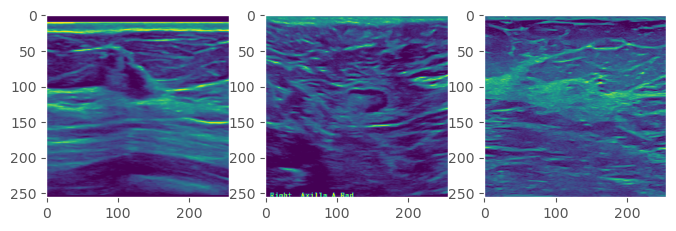

Bag number: 1


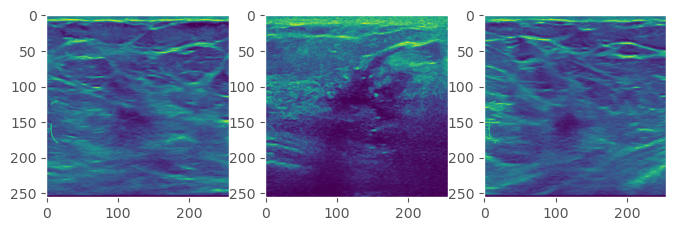

The bag class label is negative
Bag number: 239


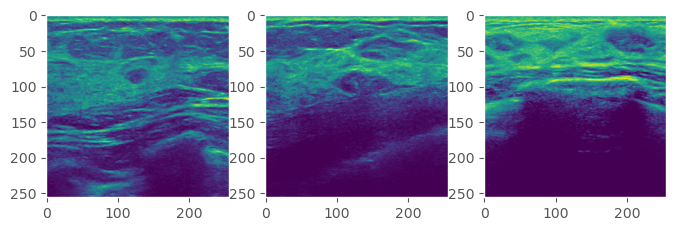

Bag number: 250


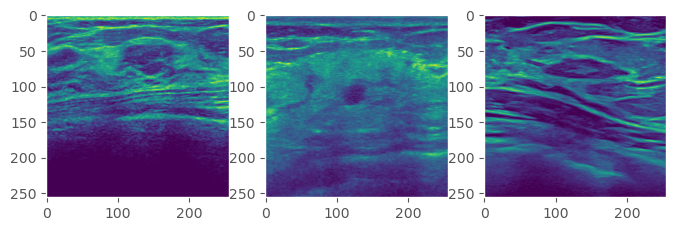

In [18]:
# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [19]:
def create_model(instance_shape):
    print("create_model input shape:", instance_shape)

    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_conv_layer = layers.Conv2D(32, (3, 3), activation="relu")
    shared_pool_layer = layers.MaxPooling2D((2, 2))
    shared_dense_layer = layers.Dense(64, activation="relu")

    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        conv = shared_conv_layer(inp)
        pool = shared_pool_layer(conv)
        flatten = layers.Flatten()(pool)
        dense = shared_dense_layer(flatten)
        inputs.append(inp)
        embeddings.append(dense)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.L2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(1, activation="sigmoid")(concat)

    return keras.Model(inputs, output)

In [20]:
def compute_class_weights(labels):
    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

In [21]:
def train(train_data, train_labels, val_data, val_labels, model):
    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.
    print("train_data shape:", np.array(train_data).shape)
    print("train_labels shape:", train_labels.shape)
    print("val_data shape:", np.array(val_data).shape)
    print("val_labels shape:", val_labels.shape)
    instance_shape = train_data[0][0].shape
    print("Instance shape:", instance_shape)

    metrics_monitored = {"metric": "val_loss", "mode": "min"}

    # Take the file name from the wrapper.
    file_path = f"weights/{timestamp}/{metrics_monitored['mode']}_{metrics_monitored['metric']}.weights.h5"

    # Create directory if it doesn't exist.
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Initialize model checkpoint callback.
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor=metrics_monitored["metric"],
        verbose=1,
        mode=metrics_monitored["mode"],
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=metrics_monitored["metric"],
        patience=10,
        mode=metrics_monitored["mode"],
        verbose=1,
        restore_best_weights=True,
    )

    # Compile model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00008),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            "AUC",
        ],
    )

    print("Model input shape:", model.input_shape)
    print("Model output shape:", model.output_shape)

    print("train_data type:", type(train_data))
    print("train_data length:", len(train_data))
    if isinstance(train_data, list):
        print("train_data[0] shape:", np.array(train_data[0]).shape)
    print("train_labels shape:", train_labels.shape)

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=200,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model

In [22]:
# Building model(s).
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(models[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

create_model input shape: (256, 256, 1)
MILAttentionLayer input shapes: [TensorShape([None, 64]), TensorShape([None, 64]), TensorShape([None, 64])]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        320 │ input_layer[0][0… │
│                     │ 32)               │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0],     │
│ (MaxPooling2D)      │ 32)               │            │ conv2d[1][0],     │
│                     │                   │            │ conv2d[2][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 516128)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 516128)    │          0 │ max_pooling2d[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 516128)    │          0 │ max_pooling2d[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │ 33,032,256 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha               │ [(None, 1),       │     33,024 │ dense[0][0],      │
│ (MILAttentionLayer) │ (None, 1), (None, │            │ dense[1][0],      │
│                     │ 1)]               │            │ dense[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ alpha[0][0],      │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64)        │          0 │ alpha[0][1],      │
│ (Multiply)          │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64)        │          0 │ alpha[0][2],      │
│ (Multiply)          │                   │            │ dense[2][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ multiply_1[0][0], │
│                     │                   │            │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        193 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,065,793 (126.14 MB)

 Trainable params: 33,065,793 (126.14 MB)

 Non-trainable params: 0 (0.00 B)

None


  0%|          | 0/1 [00:00<?, ?it/s]

train_data shape: (3, 1057, 256, 256, 1)
train_labels shape: (1057, 1)
val_data shape: (3, 704, 256, 256, 1)
val_labels shape: (704, 1)
Instance shape: (256, 256, 1)
Model input shape: [(None, 256, 256, 1), (None, 256, 256, 1), (None, 256, 256, 1)]
Model output shape: (None, 1)
train_data type: <class 'list'>
train_data length: 3
train_data[0] shape: (1057, 256, 256, 1)
train_labels shape: (1057, 1)
Epoch 1/200
MILAttentionLayer input shapes: [TensorShape([1, 64]), TensorShape([1, 64]), TensorShape([1, 64])]
MILAttentionLayer input shapes: [TensorShape([1, 64]), TensorShape([1, 64]), TensorShape([1, 64])]


2024-08-21 14:45:10.958290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 14:45:11.098956: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1048/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.3140 - accuracy: 0.9126 - loss: 4.0251MILAttentionLayer input shapes: [TensorShape([1, 64]), TensorShape([1, 64]), TensorShape([1, 64])]

Epoch 1: val_loss improved from inf to 1.85773, saving model to weights/20240821T144453/min_val_loss.weights.h5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.3156 - accuracy: 0.9109 - loss: 4.0122 - val_AUC: 0.4931 - val_accuracy: 0.0057 - val_loss: 1.8577
Epoch 2/200
1048/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7434 - accuracy: 0.6274 - loss: 1.2528
Epoch 2: val_loss improved from 1.85773 to 1.36514, saving model to weights/20240821T144453/min_val_loss.weights.h5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.7433 - accuracy: 0.6284 - loss: 1.2528 - val_AUC: 0.4670 - val_accuracy: 0.3324 - val_loss: 1.3651
Epoch 3/200
1047/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8018 - accuracy: 0.6875 - loss: 0.9555
Epoch 3: val_loss improved from 1.36514 to 0.87465, saving model to weight

In [23]:
def predict(data, labels, trained_models):
    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []
    models_auc_scores = []

    for model in trained_models:
        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        temp = model.evaluate(data, labels, verbose=1)
        print(f"len_temp: {len(temp)}")
        print(f"temp: {temp}")

        (
            loss,
            accuracy,
            auc,
        ) = model.evaluate(data, labels, verbose=1)
        models_losses.append(loss)
        models_accuracies.append(accuracy)
        models_auc_scores.append(auc)

    print(
        f"Average loss: {np.mean(models_losses)}",
        f"Average accuracy: {np.mean(models_accuracies)}",
        f"Average auc score: {np.mean(models_auc_scores)}",
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )

MILAttentionLayer input shapes: [TensorShape([32, 64]), TensorShape([32, 64]), TensorShape([32, 64])]
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
MILAttentionLayer input shapes: [TensorShape([32, 64]), TensorShape([32, 64]), TensorShape([32, 64])]
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MILAttentionLayer input shapes: [TensorShape([None, 64]), TensorShape([None, 64]), TensorShape([None, 64])]
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.3216 - accuracy: 0.9950 - loss: 0.0827  
len_temp: 3
temp: [0.09151120483875275, 0.9943181872367859, 0.46219685673713684]
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.3216 - accuracy: 0.9950 - loss: 0.0827 
Average loss: 0.09151120483875275 Average accuracy: 0.9943181872367859 Average auc score: 0.46219685673713684
The bag class label is positive
The bag class label is negative
Bag number: 0


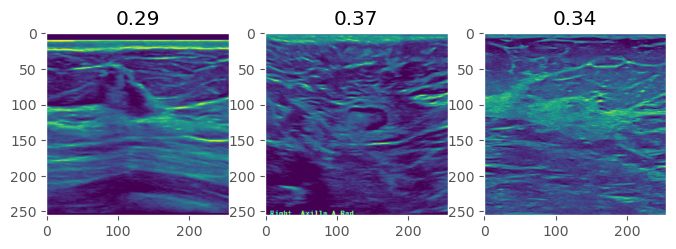

Bag number: 1


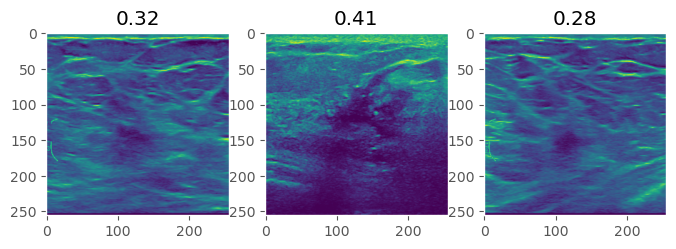

In [24]:
# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

# Plot some results from our validation data.
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)